# Machine Learning - Assignment 8

Last assignment from Andrew Ng's Machine Learning Course in Python. This last one, is the most comprehensive one focusing on Anomaly Detection and Recomender Systems. Ex_7 problems were really tough, what a better way to end the course with a tougher problem!. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.optimize as op
from scipy.io import loadmat
from scipy.stats import multivariate_normal
import matplotlib.image as mpimg

## Problem 1: Anomaly Detection

We will implement an anomaly detection algorithm to detect anomalous behavior in server computers.

In [2]:
data = loadmat('./data/ex8data1.mat')
X = data["X"]
Xval, yval = data["Xval"], data['yval'].ravel()
print(X.shape)
print(Xval.shape, yval.shape)

(307, 2)
(307, 2) (307,)


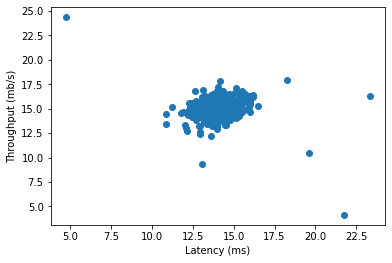

In [3]:
plt.figure()
plt.scatter(X[:,0],X[:,1])
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

### Estimating Gaussian Parameters

To calculate our probability density function, we first need to estimate our gaussian parameters.
$$µ_i=\frac{1}{m}∑^m_{j=1}x^j$$
$$\sigma^2_i=\frac{1}{m}∑^m_{j=1}(x^j-µ_i)^2$$

In [4]:
def estimateGaussian(X):
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

In [5]:
mu, sigma2 = estimateGaussian(X)
print('Mean =',mu)
print('Variance =',sigma2)

Mean = [14.11222578 14.99771051]
Variance = [1.83263141 1.70974533]


### Plotting Gaussian Distribution Bell-shaped curve 

In [6]:
def visualizeFit(distribution, X):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    X_plot = np.c_[xx.ravel(), yy.ravel()]
    y_plot = distribution.pdf(X_plot).reshape(xx.shape)

    plt.figure()
    plt.scatter(X[:, 0], X[:, 1])
    plt.contour(xx, yy, y_plot, levels=[1e-20, 1e-17, 1e-14, 1e-11, 1e-8, 1e-5, 1e-2])
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughput (mb/s)")
    plt.show()

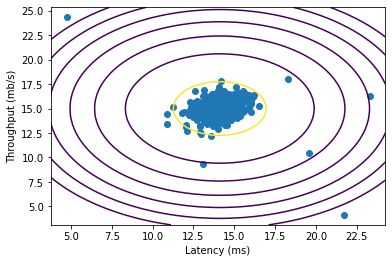

In [7]:
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
visualizeFit(distribution, X)

### Selecting the threshold

In [8]:
def selectThreshold(yval, pval):
    F1_opt = 0
    epsilon_opt = 0
    for epsilon in np.linspace(min(pval)*1.01, max(pval), 1000):
        prediction = (pval < epsilon)
        tp = np.sum(np.multiply(prediction, yval))
        fp = np.sum(np.multiply(prediction, 1-yval))
        fn = np.sum(np.multiply(1-prediction, yval))
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        F1 = (2*precision*recall)/(precision+recall)
        if F1 > F1_opt:
            F1_opt = F1
            epsilon_opt = epsilon
    return epsilon_opt, F1_opt

In [9]:
pval = distribution.pdf(Xval)
epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)

Best epsilon found using cross-validation: 9.00e-05
Best F1 on Cross Validation Set:  0.875000


In [10]:
def visualizeFitUP(distribution, X, outliers):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    X_plot = np.c_[xx.ravel(), yy.ravel()]
    y_plot = distribution.pdf(X_plot).reshape(xx.shape)

    plt.figure()
    plt.scatter(X[:, 0], X[:, 1])
    plt.contour(xx, yy, y_plot, levels=[1e-20, 1e-17, 1e-14, 1e-11, 1e-8, 1e-5, 1e-2])
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughput (mb/s)")
    plt.scatter(X[outliers, 0], X[outliers, 1], s=100)
    plt.show()

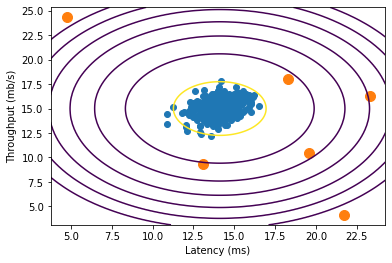

# Outliers found: 6


In [11]:
p = distribution.pdf(X)
outliers = p < epsilon
visualizeFitUP(distribution, X, outliers)
print('# Outliers found: %d' % sum(outliers))

### High Dimensional Data

Finally, we do the same but insted of a 3dim data, we use high dimensional data (11dim data)

In [12]:
data2 = loadmat('./data/ex8data2.mat')
X = data2["X"]
Xval, yval = data2["Xval"], data2['yval'].ravel()
print(X.shape)
print(Xval.shape, yval.shape)

(1000, 11)
(100, 11) (100,)


In [13]:
mu, sigma2 = estimateGaussian(X)
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
p = distribution.pdf(X) #training set
pval = distribution.pdf(Xval) #CV set
epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)
print('# Outliers found: %d' % sum(p < epsilon))

Best epsilon found using cross-validation: 1.38e-18
Best F1 on Cross Validation Set:  0.615385
# Outliers found: 117


## Problem 2: Recommender System

We will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings*. This dataset consists of ratings on a scale of 1 to 5. The dataset has  users, and  movies

In [14]:
movies = loadmat("./data/ex8_movies.mat")
Y, R = movies["Y"], movies["R"]
print(Y.shape, R.shape)

(1682, 943) (1682, 943)


- Y is a 1682 x 943 matrix, containing ratings (1 - 5) of 1682 movies on 943 users
- R is a 1682 x 943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i

In [22]:
print('Average rating for movie 1 (Toy Story): %f out of 5' % np.mean(Y[0, R[0] == 1]))

Average rating for movie 1 (Toy Story): 3.878319 out of 5


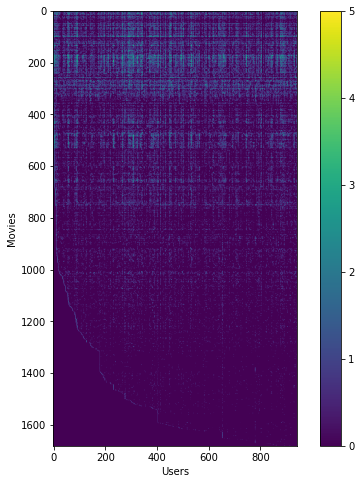

In [33]:
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.xlabel("Users")
plt.ylabel("Movies")
plt.colorbar()
plt.show()

### Collaborative Filtering Algo

In [35]:
movies_p = loadmat("./data/ex8_movieParams.mat")
X, Theta = movies_p["X"], movies_p["Theta"]
print(X.shape, Theta.shape)

(1682, 10) (943, 10)


- X is a 1682 x 10 matrix, containing 10 movie categories of 1682 movies (from 0-1, 0 not and 1 yes)
- Theta is a 943 x 10 matrix, is our learning parameters tied to Y (1682 movies x 942 users) and X (1682 movies and 10 posible categories)

In [36]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features]
    X = X.reshape((num_movies, num_features))
    Theta = params[num_movies * num_features:]
    Theta = Theta.reshape((num_users, num_features))

    J = np.sum(np.multiply(np.power(np.dot(X, Theta.T) - Y, 2), R)) / 2
    J += np.sum(np.power(Theta, 2)) * lam / 2
    J += np.sum(np.power(X, 2)) * lam / 2

    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    for i in range(num_movies):
        idx = (R[i] == 1)
        Theta_temp = Theta[idx]
        Y_temp = Y[i, idx]
        X_grad[i] = np.dot(np.dot(Theta_temp, X[i]) - Y_temp, Theta_temp)
        X_grad[i] += lam * X[i]
    for i in range(num_users):
        idx = (R[:, i] == 1)
        X_temp = X[idx]
        Y_temp = Y[idx, i]
        Theta_grad[i] = np.dot(np.dot(X_temp, Theta[i]) - Y_temp, X_temp)
        Theta_grad[i] += lam * Theta[i]
    grad = np.hstack((X_grad.ravel(), Theta_grad.ravel()))
    return J, grad

In [43]:
def cost(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features]
    X = X.reshape((num_movies, num_features))
    Theta = params[num_movies * num_features:]
    Theta = Theta.reshape((num_users, num_features))

    J = np.sum(np.multiply(np.power(np.dot(X, Theta.T) - Y, 2), R)) / 2
    J += np.sum(np.power(Theta, 2)) * lam / 2
    J += np.sum(np.power(X, 2)) * lam / 2
    return J

def gradient(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features]
    X = X.reshape((num_movies, num_features))
    Theta = params[num_movies * num_features:]
    Theta = Theta.reshape((num_users, num_features))

    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    for i in range(num_movies):
        idx = (R[i] == 1)
        Theta_temp = Theta[idx]
        Y_temp = Y[i, idx]
        X_grad[i] = np.dot(np.dot(Theta_temp, X[i]) - Y_temp, Theta_temp)
        X_grad[i] += lam * X[i]
    for i in range(num_users):
        idx = (R[:, i] == 1)
        X_temp = X[idx]
        Y_temp = Y[idx, i]
        Theta_grad[i] = np.dot(np.dot(X_temp, Theta[i]) - Y_temp, X_temp)
        Theta_grad[i] += lam * Theta[i]
    grad = np.hstack((X_grad.ravel(), Theta_grad.ravel()))
    return grad

In [44]:
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [45]:
params = np.hstack((X.ravel(), Theta.ravel()))
J, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 0)
print('Cost at loaded parameters:  %.2f' % J)

Cost at loaded parameters:  22.22


To check if our gradients are correct, MALTAB runs a function called checkcostfunction, but we can do this in Python

In [46]:
num_grad = np.zeros(len(grad))
e = 1e-4
for i in range(len(grad)):
    params1 = params.copy()
    params1[i] += e
    cost1 = cost(params1, Y, R, num_users, num_movies, num_features, 0)
    params2 = params.copy()
    params2[i] -= e
    cost2 = cost(params2, Y, R, num_users, num_movies, num_features, 0)
    num_grad[i] = (cost1 - cost2) / (2 * e)
print(grad[:5])
print(num_grad[:5])
assert np.linalg.norm(grad - num_grad) / np.linalg.norm(grad + num_grad) < 1e-9

[-2.52899165  7.57570308 -1.89979026 -0.56819597  3.35265031]
[-2.52899165  7.57570308 -1.89979026 -0.56819597  3.35265031]


Now using parametrization and setting lambda to 1.5

In [47]:
params = np.hstack((X.ravel(), Theta.ravel()))
J, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 1.5)
print('Cost at loaded parameters:  %.2f' % J)

Cost at loaded parameters:  31.34


In [49]:
num_grad = np.zeros(len(grad))
e = 1e-4
for i in range(len(grad)):
    params1 = params.copy()
    params1[i] += e
    cost1 = cost(params1, Y, R, num_users, num_movies, num_features, 1.5)
    params2 = params.copy()
    params2[i] -= e
    cost2 = cost(params2, Y, R, num_users, num_movies, num_features, 1.5)
    num_grad[i] = (cost1 - cost2) / (2 * e)
print(grad[:5])
print(num_grad[:5])
assert np.linalg.norm(grad - num_grad) / np.linalg.norm(grad + num_grad) < 1e-9

[-0.95596339  6.97535514 -0.10861109  0.60308088  2.77421145]
[-0.95596339  6.97535514 -0.10861109  0.60308088  2.77421145]


### Problem 2.3: Learning movie recommendation

In [50]:
movieList = {}
input_file = open("./data/movie_ids.txt", encoding="latin-1")
for line in input_file.readlines():
    movie_info = line.strip().split(" ")
    movieList[int(movie_info[0]) - 1] = " ".join(movie_info[1:])
input_file.close()

After loading the data, we initialize our ratings matrix

In [59]:
ratings = np.zeros(len(movieList))

Check the file movie_idx.txt for id of each movie in our dataset. For example, Toy Story (1995) has ID 1, so to rate it "4", you can set. Then, we can rate other movies we have seen

In [62]:
ratings[0] = 4 #toy story example
ratings[6] = 3
ratings[11]= 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

In [67]:
print('New user ratings:')
print('-----------------')
for i in range(len(ratings)):
    if ratings[i] > 0:
        print('Rated %d⭐ : %s' % (ratings[i], movieList[i]))

New user ratings:
-----------------
Rated 4⭐ : Toy Story (1995)
Rated 3⭐ : Twelve Monkeys (1995)
Rated 5⭐ : Usual Suspects, The (1995)
Rated 4⭐ : Outbreak (1995)
Rated 5⭐ : Shawshank Redemption, The (1994)
Rated 3⭐ : While You Were Sleeping (1995)
Rated 5⭐ : Forrest Gump (1994)
Rated 4⭐ : Alien (1979)
Rated 5⭐ : Die Hard 2 (1990)
Rated 5⭐ : Sphere (1998)


After rating a few movies, we load our dataset from movies, so with our ratings, our model can lear which are our favorite "movie categories" and recommend new similar movies.

In [69]:
data = loadmat("./data/ex8_movies.mat")
Y, R = data["Y"], data["R"]
print(Y.shape, R.shape)
Y = np.hstack((ratings[:, np.newaxis], Y))
R = np.hstack((((ratings != 0).astype(int))[:, np.newaxis], R))
print(Y.shape, R.shape)

(1682, 943) (1682, 943)
(1682, 944) (1682, 944)


Need to normalize our data

In [70]:
def normalizeRatings(Y, R):
    Ymean = np.zeros(Y.shape[0])
    Ynorm = np.zeros(Y.shape)
    for i in range(Y.shape[0]):
        idx = (R[i] == 1)
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
    return Ymean, Ynorm

Because we are runnig this in a local machine, we need to lower our features number aka how many users have rated movies (from the 943 to 10). If you have a GPU or running which high computing power you can def try all 943 users.

In [72]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10
rng = np.random.RandomState(0)
X = rng.randn(num_movies, num_features)
Theta = rng.randn(num_users, num_features)
params = np.hstack((X.ravel(), Theta.ravel()))
lam = 10
Ymean, Ynorm = normalizeRatings(Y, R)
res = op.minimize(fun=cost, x0=params,
                        args=(Ynorm, R, num_users, num_movies, num_features, lam),
                        method='CG', jac=gradient, options={"maxiter": 100})

In [ ]:
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)

In [73]:
X = res.x[:num_movies * num_features]
X = X.reshape((num_movies, num_features))
Theta = res.x[num_movies * num_features:]
Theta = Theta.reshape((num_users, num_features))

In [74]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

In [82]:
print('Top recommendations for you:')
print('----------------------------')
for idx in np.argsort(my_predictions)[::-1][:10]:
    print('Predicting rating %d⭐ for movie %s' % (my_predictions[idx], movieList[idx]))

Top recommendations for you:
----------------------------
Predicting rating 5⭐ for movie Aiqing wansui (1994)
Predicting rating 5⭐ for movie Great Day in Harlem, A (1994)
Predicting rating 5⭐ for movie Someone Else's America (1995)
Predicting rating 5⭐ for movie They Made Me a Criminal (1939)
Predicting rating 5⭐ for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5⭐ for movie Saint of Fort Washington, The (1993)
Predicting rating 4⭐ for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 4⭐ for movie Star Kid (1997)
Predicting rating 4⭐ for movie Prefontaine (1997)
Predicting rating 4⭐ for movie Santa with Muscles (1996)


This output can be interpreted as a recommendation of movies with highest predicted rating I would have given based on the rating I already gave above